# World-wide antibiotics resistance mapping using Geopandas.

Antibiotic resistance is being increasingly detected in bacteria. Of concern, is the rise in resistance towards antibiotics of last-resort. 

We will use the Geopandas library in Python as a tool to draw attention to antibiotic resistance globallyby using 2 data sources:
 1. A resistance scoring dataset, whereby the resistance scores 1 through 3 correspond to increasing resistance in bacteria to last-resort antibiotics.
 2. A dataset sourced from ArcGIS with geographical coordinates for each country.

We will source geometry information for all of the countries in the world, and merge this data with another data source which lists antibiotic resistance scores worldwide.

Then we will produce a global mapping of antibiotic resistance worldwide which will serve as a useful summary info-graphic to aid in the detection of high and low resistance areas.

Further, by plotting an entire map including areas where no information is available will expose areas where surveillance may be lacking (for the dataset used here).

In [15]:
#import libraries 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

Reading in Shape file with geometry data for each country

Available from:
https://hub.arcgis.com/datasets/a21fdb46d23e4ef896f31475217cbb08_1?geometry=151.172%2C-89.998%2C-151.172%2C-79.513

In [16]:
#import geojson file and store in a variable called gdf (geodataframe)

gdf= gpd.read_file("Longitude_Graticules_and_World_Countries_Boundaries.geojson")

In [17]:
#look at the head (first 5 lines) of the data 
gdf.head()

,OBJECTID,CNTRY_NAME,geometry
0,1,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,3,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,4,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,5,Azerbaijan,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41..."


In [18]:
gdf.dtypes

OBJECTID         int64
CNTRY_NAME      object
geometry      geometry
dtype: object

In [19]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

Reading in csv file with Resistance level scores¶

In [20]:
#read in the resistance scores dataset, using pandas read_csv function
res = pd.read_csv('resistance_score__Country__res_0-3_vir_0-5.csv')

In [21]:
#check the head of the DataFrame to confirm data has correctly parsed
res.head()

,group,annotation
0,USA,"0: ESBL-, Carb-"
1,USA,"0: ESBL-, Carb-"
2,USA,"0: ESBL-, Carb-"
3,USA,"0: ESBL-, Carb-"
4,USA,"0: ESBL-, Carb-"


In [22]:
#Create a new column (by extracting the scores using lambda function).
res['resistance_scores'] = res['annotation'].apply(lambda x: int(x[0]))
res.drop('annotation', axis=1, inplace=True)

In [23]:
res.columns = ['country', 'resistance_scores'] ##columns have been renamed to accurately reflect their contents

In [24]:
#look at the head of the dataframe with the new changes made
res.head()

,country,resistance_scores
0,USA,0
1,USA,0
2,USA,0
3,USA,0
4,USA,0


In [14]:
res.groupby('country').mean()['resistance_scores'].sort_values(ascending=False)

country
Venezuela               3.000000
Uruguay                 3.000000
United Arab Emirates    3.000000
Peru                    2.500000
Honduras                2.000000
                          ...   
Senegal                 0.009901
USA                     0.000000
Morocco                 0.000000
New Zealand             0.000000
Martinique              0.000000
Name: resistance_scores, Length: 96, dtype: float64

# We want to have representative countries
To do this, we will only plot countries with information on >= 10 isolates

In [25]:
res_10 = res.groupby('country').size()[res.groupby('country').size() >= 10].sort_values(ascending=False)

In [26]:
res_10

country
USA            1739
China          1262
UK              841
Italy           757
Thailand        526
               ... 
Philippines      12
New Zealand      11
Chile            11
Sri Lanka        10
Sweden           10
Length: 67, dtype: int64

In [27]:
representative_countries = res_10.index.to_list()

# Now lets look at the top 10 representative countries
some data cleaning required because there are entries such as 'unknown' which do not match up to a country

In [28]:
representative_countries[:10]

['USA',
 'China',
 'UK',
 'Italy',
 'Thailand',
 'Australia',
 'unknown',
 'France',
 'Spain',
 'Caribbean']

In [29]:
res = pd.DataFrame(res.groupby('country').mean()['resistance_scores'].sort_values(ascending=False))

In [31]:
res = res[res.index.isin(representative_countries)].reset_index()


In [32]:
res

,country,resistance_scores
0,Sri Lanka,2.000000
1,Brazil,1.985437
2,Greece,1.963158
3,Switzerland,1.822917
4,Montenegro,1.736842
...,...,...
62,Hong Kong,0.148148
63,Japan,0.146552
64,Madagascar,0.109890
65,Senegal,0.009901


In [33]:
data_countries = res['country'].to_list()

I do a merge on both datasets later on, so I have changed the name of the column from 'CNTRY_NAME' to 'country' in the gdf geopandas Dataframe

In [34]:
gdf.columns = ['OBJECTID', 'country', 'geometry']

In [35]:
gdf

,OBJECTID,country,geometry
0,1,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,3,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,4,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,5,Azerbaijan,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41..."
...,...,...,...
246,247,Western Samoa,"MULTIPOLYGON (((-172.59650 -13.50911, -172.551..."
247,248,Swaziland,"POLYGON ((30.89944 -26.77195, 30.88028 -26.793..."
248,249,Yemen,"MULTIPOLYGON (((48.68639 14.03750, 48.61000 14..."
249,250,Zambia,"POLYGON ((30.21302 -14.98172, 30.21917 -15.096..."


In [36]:
all_countries = gdf['country'].to_list()

# Data cleaning
finding out shared countries and making sure country names match up.

In [37]:
same_countries = []
different_countries = []


for country in data_countries:
    if country not in all_countries:
        different_countries.append(country)
    else:
        same_countries.append(country)

In [38]:
len(same_countries)

61

In [39]:
different_countries

['USA', 'unknown', 'Tanzania', 'UK', 'Caribbean', 'Hong Kong']

In [40]:
res[res['country'] == 'unknown']

,country,resistance_scores
32,unknown,1.175476


In [41]:
res[res['country'] == 'Caribbean']

,country,resistance_scores
61,Caribbean,0.354067


In [42]:
res[res['country'] == 'Hong Kong']

,country,resistance_scores
62,Hong Kong,0.148148


In [43]:
res = res.drop([32, 61, 62])

In [44]:
res

,country,resistance_scores
0,Sri Lanka,2.000000
1,Brazil,1.985437
2,Greece,1.963158
3,Switzerland,1.822917
4,Montenegro,1.736842
...,...,...
60,Estonia,0.375000
63,Japan,0.146552
64,Madagascar,0.109890
65,Senegal,0.009901


# The country names in the dataset should be:
 - United Kingdom,
 - Tanzania, United Republic of,
 - United States. 
 
 ##to do bullet points in markdown do (space - space)
 

In [45]:
res[(res['country'] == 'UK') |
    (res['country'] == 'Tanzania') |
    (res['country'] == 'USA')]

,country,resistance_scores
18,USA,1.447959
50,Tanzania,0.600000
52,UK,0.571938


In [46]:
# use the pandas at method to change this to their more official names
res.at[18, 'country'] = 'United States'
res.at[50, 'country'] = 'Tanzania, United Republic of'
res.at[52, 'country'] = 'United Kingdom'

In [47]:
# confirm name change
res[(res['country'] == 'United States') |
    (res['country'] == 'Tanzania, United Republic of') |
    (res['country'] == 'United Kingdom')]

,country,resistance_scores
18,United States,1.447959
50,"Tanzania, United Republic of",0.600000
52,United Kingdom,0.571938


# Merge both Dataframes

In [48]:
data = gdf[gdf['country'].isin(res['country'].to_list())]

In [49]:
res_df = res.merge(data, on='country')

In [50]:
res_df

,country,resistance_scores,OBJECTID,geometry
0,Sri Lanka,2.000000,39,"MULTIPOLYGON (((81.78526 6.67250, 81.78457 6.6..."
1,Brazil,1.985437,30,"MULTIPOLYGON (((-70.62862 -9.94849, -70.62889 ..."
2,Greece,1.963158,92,"MULTIPOLYGON (((21.08305 39.05666, 21.04528 39..."
3,Switzerland,1.822917,214,"POLYGON ((8.99833 45.82944, 8.95111 45.84528, ..."
4,Montenegro,1.736842,156,"POLYGON ((18.45555 42.56583, 18.46389 42.56944..."
...,...,...,...,...
59,Estonia,0.375000,65,"MULTIPOLYGON (((27.37206 57.53564, 27.31028 57..."
60,Japan,0.146552,113,"MULTIPOLYGON (((144.36774 43.95388, 144.41109 ..."
61,Madagascar,0.109890,138,"MULTIPOLYGON (((46.32916 -15.64500, 46.33167 -..."
62,Senegal,0.009901,199,"POLYGON ((-14.34175 12.67889, -14.39306 12.678..."


In [51]:
others = gdf[~gdf['country'].isin(res['country'].to_list())]

In [52]:
others['resistance_scores'] = np.NaN

C:\Anaconda3\envs\myenv\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [53]:
res_geo = pd.concat([res_df, others])

In [54]:
res_geo

,country,resistance_scores,OBJECTID,geometry
0,Sri Lanka,2.000000,39,"MULTIPOLYGON (((81.78526 6.67250, 81.78457 6.6..."
1,Brazil,1.985437,30,"MULTIPOLYGON (((-70.62862 -9.94849, -70.62889 ..."
2,Greece,1.963158,92,"MULTIPOLYGON (((21.08305 39.05666, 21.04528 39..."
3,Switzerland,1.822917,214,"POLYGON ((8.99833 45.82944, 8.95111 45.84528, ..."
4,Montenegro,1.736842,156,"POLYGON ((18.45555 42.56583, 18.46389 42.56944..."
...,...,...,...,...
246,Western Samoa,NaN,247,"MULTIPOLYGON (((-172.59650 -13.50911, -172.551..."
247,Swaziland,NaN,248,"POLYGON ((30.89944 -26.77195, 30.88028 -26.793..."
248,Yemen,NaN,249,"MULTIPOLYGON (((48.68639 14.03750, 48.61000 14..."
249,Zambia,NaN,250,"POLYGON ((30.21302 -14.98172, 30.21917 -15.096..."


In [55]:
type(res_geo)

pandas.core.frame.DataFrame

In [56]:
res_geo = gpd.GeoDataFrame(res_geo)

In [57]:
type(res_geo)

geopandas.geodataframe.GeoDataFrame

# Patchy appearance

<AxesSubplot:>

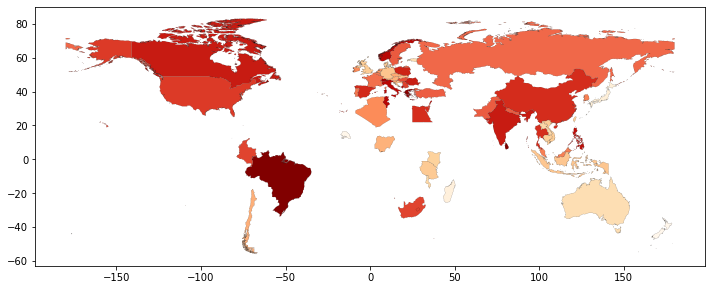

In [58]:
res_geo.plot(figsize=(12, 16), column=res_geo['resistance_scores'], cmap='OrRd',
            edgecolor = 'black',
            linewidth = 0.1)

# We need to make it more complete:

<AxesSubplot:>

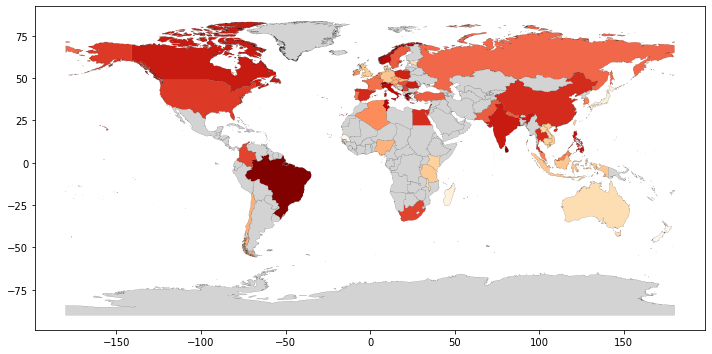

In [59]:
res_geo.plot(figsize=(12, 16), column=res_geo['resistance_scores'], cmap='OrRd', k=6,
            missing_kwds= { 'color' : "lightgrey"},
            edgecolor = 'black',
            linewidth = 0.1)

In [60]:
res_geo = res_geo[res_geo['country'] != 'Antarctica']

<AxesSubplot:>

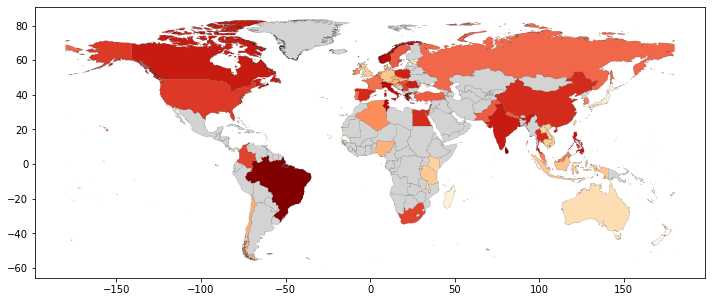

In [61]:
res_geo.plot(figsize=(12, 16), column=res_geo['resistance_scores'], cmap='OrRd', k=6,
            missing_kwds= { 'color' : "lightgrey"},
            edgecolor = 'black',
            linewidth = 0.1)

# Improve the quality

 - Add a key/legend,
 - Position legend sensibly,
 - Vibrate colour mapping,
 - Remove the border.  

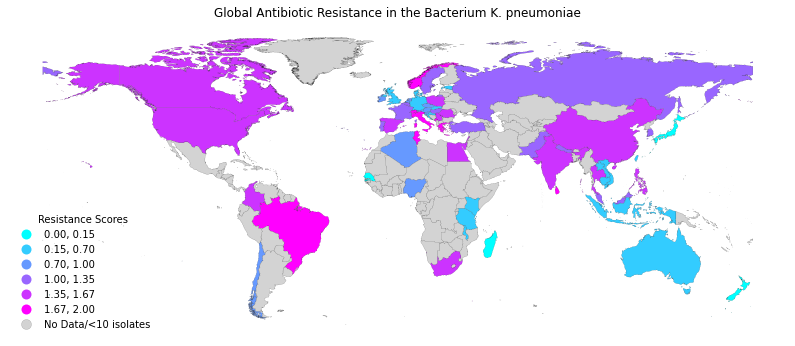

In [62]:
fig, ax = plt.subplots(figsize=(14, 16))

res_geo.plot(ax=ax, figsize=(14, 16), column=res_geo['resistance_scores'], cmap='cool', k=6,
            missing_kwds=dict(color="lightgrey",label='No Data/<10 isolates'),
            scheme='FisherJenks',
            edgecolor = 'black',
            legend=True, 
            linewidth = 0.1,
            legend_kwds=dict(loc='lower left', frameon=False, title='Resistance Scores'))

ax.set(title='Global Antibiotic Resistance in the Bacterium K. pneumoniae')
ax.set_axis_off()


plt.show()